In [1]:
# Install hdf5 library by interacting with the interpreter 
import sys
!{sys.executable} -m pip install hdf5storage
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install bayesian_optimization
!{sys.executable} -m pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from os import listdir
import random
import tqdm
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adadelta, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from tensorflow.keras.layers import Input, RepeatVector, Reshape
from tensorflow.keras.losses import mse
from tensorflow.keras.models import Model
from keras.regularizers import L2



from sklearn.linear_model import *
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import scipy.cluster.hierarchy as sch
import matplotlib.dates as mdates
from keras.layers import Embedding, SimpleRNN
from scipy import stats
from google.colab import drive
from pprint import pprint
from pylab import mpl
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
# pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'
%matplotlib inline
tf.random.set_seed(100)


In [3]:
# Import Libraries 
import scipy.io
from google.colab import drive
import pandas as pd
import numpy as np
import h5py
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import hdf5storage
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization
from gc import callbacks
from scikeras.wrappers import KerasRegressor

In [4]:
# mount the Google drive as a path that you can work on 
# drive.mount('/drive')

# make sure you set index as the Date
drive_path = "S092215-v50-AMZN_OCT2_states.mat"
LOB_input = hdf5storage.loadmat(drive_path)
df_orig = pd.DataFrame.from_dict(LOB_input['LOB'])

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [5]:
# Reference : Seminar Material from Course
# Column Titles - Market Depth with Bid and Ask Prices at each level as can be seen in a trading platform
df_orig.columns = [
                      "Time", "Mid_Price", "Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]

In [6]:
# # Create a new column 'Time_readable' with the datetime values
# # This converts Epoch time to normal Date-Time format %Y-%m-%d %H:%M:%S.%f
df_orig['Time'] = df_orig['Time'].apply(lambda x: dt.datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
df_orig['Time'] = pd.to_datetime(df_orig['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [7]:
start_time = pd.to_datetime('2015-09-22 09:30:00.000000')
end_time = pd.to_datetime('2015-09-22 16:00:00.000000')
# Filtering Market Hours
mask = (df_orig['Time'] >= start_time) & (df_orig['Time'] <= end_time)
filtered_df = df_orig.loc[mask]
filtered_df.head(5)

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
100289,2015-09-22 09:30:00.006,5405950,17700,5414800,1000,5397100,10,5414900,1,5396100,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
100290,2015-09-22 09:30:00.007,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
100291,2015-09-22 09:30:00.008,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
100292,2015-09-22 09:30:00.008,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
100293,2015-09-22 09:30:00.024,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100


In [8]:
# Set Time as Index 
filtered_df.set_index('Time', inplace=True)
filtered_df.head(5)

,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
Time,,,,,,,,,,,,,,,,,,,,,
2015-09-22 09:30:00.006,5405950,17700,5414800,1000,5397100,10,5414900,1,5396100,200,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
2015-09-22 09:30:00.007,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,200,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
2015-09-22 09:30:00.008,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,200,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
2015-09-22 09:30:00.008,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,200,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100
2015-09-22 09:30:00.024,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,200,...,5391100,174,5469700,34,5391000,70,5469900,100,5390000,100


In [9]:
def clean_data(df):
    """
    Clean a DataFrame by dropping columns with too many NaN values and filling in remaining NaNs.

    Args:
        df (pandas.DataFrame): A DataFrame to be cleaned.

    Returns:
        pandas.DataFrame: The cleaned DataFrame.
    """

    # Check which columns have more than 40% NaN values
    nan_counts = df.isna().sum()
    drop_cols = list(nan_counts[nan_counts >= 0.4*len(filtered_df)].index)

    # Drop columns with too many NaNs (greater than 40%)
    if len(drop_cols) > 0:
        df = df.drop(columns=drop_cols)

    # Fill first five values of remaining columns with ffill/bfill
    df = df.fillna(method='ffill', limit=5).fillna(method='bfill')

    # Fill remaining NaNs with moving average of previous 5 values
    for col in df.columns:
        if col not in drop_cols:
            # Calculate rolling mean with window size of 5
            rolling_mean = df[col].rolling(window=5, min_periods=1).mean()
            # Fill remaining NaNs with rolling mean
            df[col] = df[col].fillna(rolling_mean)

    # Drop rows with any remaining NaN values
    df.dropna(inplace=True)

    return df

filtered_df = clean_data(filtered_df)

In [10]:
def feature_engineered_values(df):
    """
    Takes a pandas DataFrame `df` containing raw financial data and applies various
    feature engineering techniques to create new features. Returns the updated DataFrame.
    
    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame containing financial data, with columns for bid and ask prices and volumes,
        as well as a 'Mid_Price' column representing the midpoint between the best bid and ask prices.
    
    Returns
    -------
    pandas.DataFrame
        A copy of the input DataFrame with additional columns representing the engineered features.
    """
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Drop any NaN rows
    df.dropna(inplace=True)

    # Calculate Order Imbalance of First Bid-Ask Volume
    df.loc[:, 'Order_Imbalance'] = (df['BidVolume1'] - df['AskVolume1']) / (df['BidVolume1'] + df['AskVolume1'])

    # Calculate direction of mid-price
    df.loc[:, 'Direction'] = df['Mid_Price'].diff().apply(lambda x: 1 if x > 0 else -1)


    # # Calculate Total Average Bid Price using 10 Bids
    # df.loc[:, 'Total_Avg_Bid_Price'] = (df['BidPrice1'] + df['BidPrice2'] + df['BidPrice3'] + df['BidPrice4'] + df['BidPrice5'] + df['BidPrice6'] + df['BidPrice7'] + df['BidPrice8'] + df['BidPrice9'] + df['BidPrice10']) / 10

    # # Calculate Total Average Ask Price using 10 Asks
    # df.loc[:, 'Total_Avg_Ask_Price'] = (df['AskPrice1'] + df['AskPrice2'] + df['AskPrice3'] + df['AskPrice4'] + df['AskPrice5'] + df['AskPrice6'] + df['AskPrice7'] + df['AskPrice8'] + df['AskPrice9'] + df['AskPrice10']) / 10

    # # Calculate Total Average Bid Volume using 10 Bids
    # df.loc[:, 'Total_Avg_Bid_Volume'] = (df['BidVolume1'] + df['BidVolume2'] + df['BidVolume3'] + df['BidVolume4'] + df['BidVolume5'] + df['BidVolume6'] + df['BidVolume7'] + df['BidVolume8'] + df['BidVolume9'] + df['BidVolume10']) / 10

    # # Calculate Total Average Ask Volume using 10 Asks
    # df.loc[:, 'Total_Avg_Ask_Volume'] = (df['AskVolume1'] + df['AskVolume2'] + df['AskVolume3'] + df['AskVolume4'] + df['AskVolume5'] + df['AskVolume6'] + df['AskVolume7'] + df['AskVolume8'] + df['AskVolume9'] + df['AskVolume10']) / 10

    # Calculate Mid-Price difference t and t-1
    df.loc[:, 'Mid_Price_Diff'] = df['Mid_Price'].diff()

    # Calculate Simple Moving Average t to t-5
    df.loc[:, 'SMA'] = df['Mid_Price'].rolling(window=5).mean()

    # # Calculate Bollinger bands
    # df.loc[:, 'Std_Dev'] = df['Mid_Price'].rolling(window=5).std()
    # df.loc[:, 'Upper_Band'] = df['SMA'] + (2 * df['Std_Dev'])
    # df.loc[:, 'Lower_Band'] = df['SMA'] - (2 * df['Std_Dev'])

    # Drop any NaN rows created by the moving average calculations
    df.dropna(inplace=True)

    return df

df_engg_values = feature_engineered_values(filtered_df)
df_engg_values.head(5)

,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,...,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10,Order_Imbalance,Direction,Mid_Price_Diff,SMA
Time,,,,,,,,,,,,,,,,,,,,,
2015-09-22 09:30:00.024,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,200,...,5391000,70,5469900,100,5390000,100,-0.818182,-1,0.0,5405950.0
2015-09-22 09:30:00.025,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,200,...,5391000,70,5469900,100,5390000,100,-0.818182,-1,0.0,5405950.0
2015-09-22 09:30:00.042,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,200,...,5391000,70,5469900,100,5390000,100,-0.818182,-1,0.0,5405950.0
2015-09-22 09:30:00.047,5405950,17700,5414800,100,5397100,10,5414900,1,5396100,300,...,5391000,70,5469900,100,5390000,100,-0.818182,-1,0.0,5405950.0
2015-09-22 09:30:00.047,5405950,17700,5414800,200,5397100,10,5414900,1,5396100,300,...,5391000,70,5469900,100,5390000,100,-0.904762,-1,0.0,5405950.0


In [11]:
# Resample the dataframe by 250 milliseconds and take the mean of each interval
df_engg_values_20ms = df_engg_values.resample('20L').last()
df_IndexChanged = df_engg_values_20ms
df_IndexChanged.dropna(inplace=True)
df_IndexChanged.isna().sum()

Mid_Price          0
Spread             0
AskPrice1          0
AskVolume1         0
BidPrice1          0
BidVolume1         0
AskPrice2          0
AskVolume2         0
BidPrice2          0
BidVolume2         0
AskPrice3          0
AskVolume3         0
BidPrice3          0
BidVolume3         0
AskPrice4          0
AskVolume4         0
BidPrice4          0
BidVolume4         0
AskPrice5          0
AskVolume5         0
BidPrice5          0
BidVolume5         0
AskPrice6          0
AskVolume6         0
BidPrice6          0
BidVolume6         0
AskPrice7          0
AskVolume7         0
BidPrice7          0
BidVolume7         0
AskPrice8          0
AskVolume8         0
BidPrice8          0
BidVolume8         0
AskPrice9          0
AskVolume9         0
BidPrice9          0
BidVolume9         0
AskPrice10         0
AskVolume10        0
BidPrice10         0
BidVolume10        0
Order_Imbalance    0
Direction          0
Mid_Price_Diff     0
SMA                0
dtype: int64

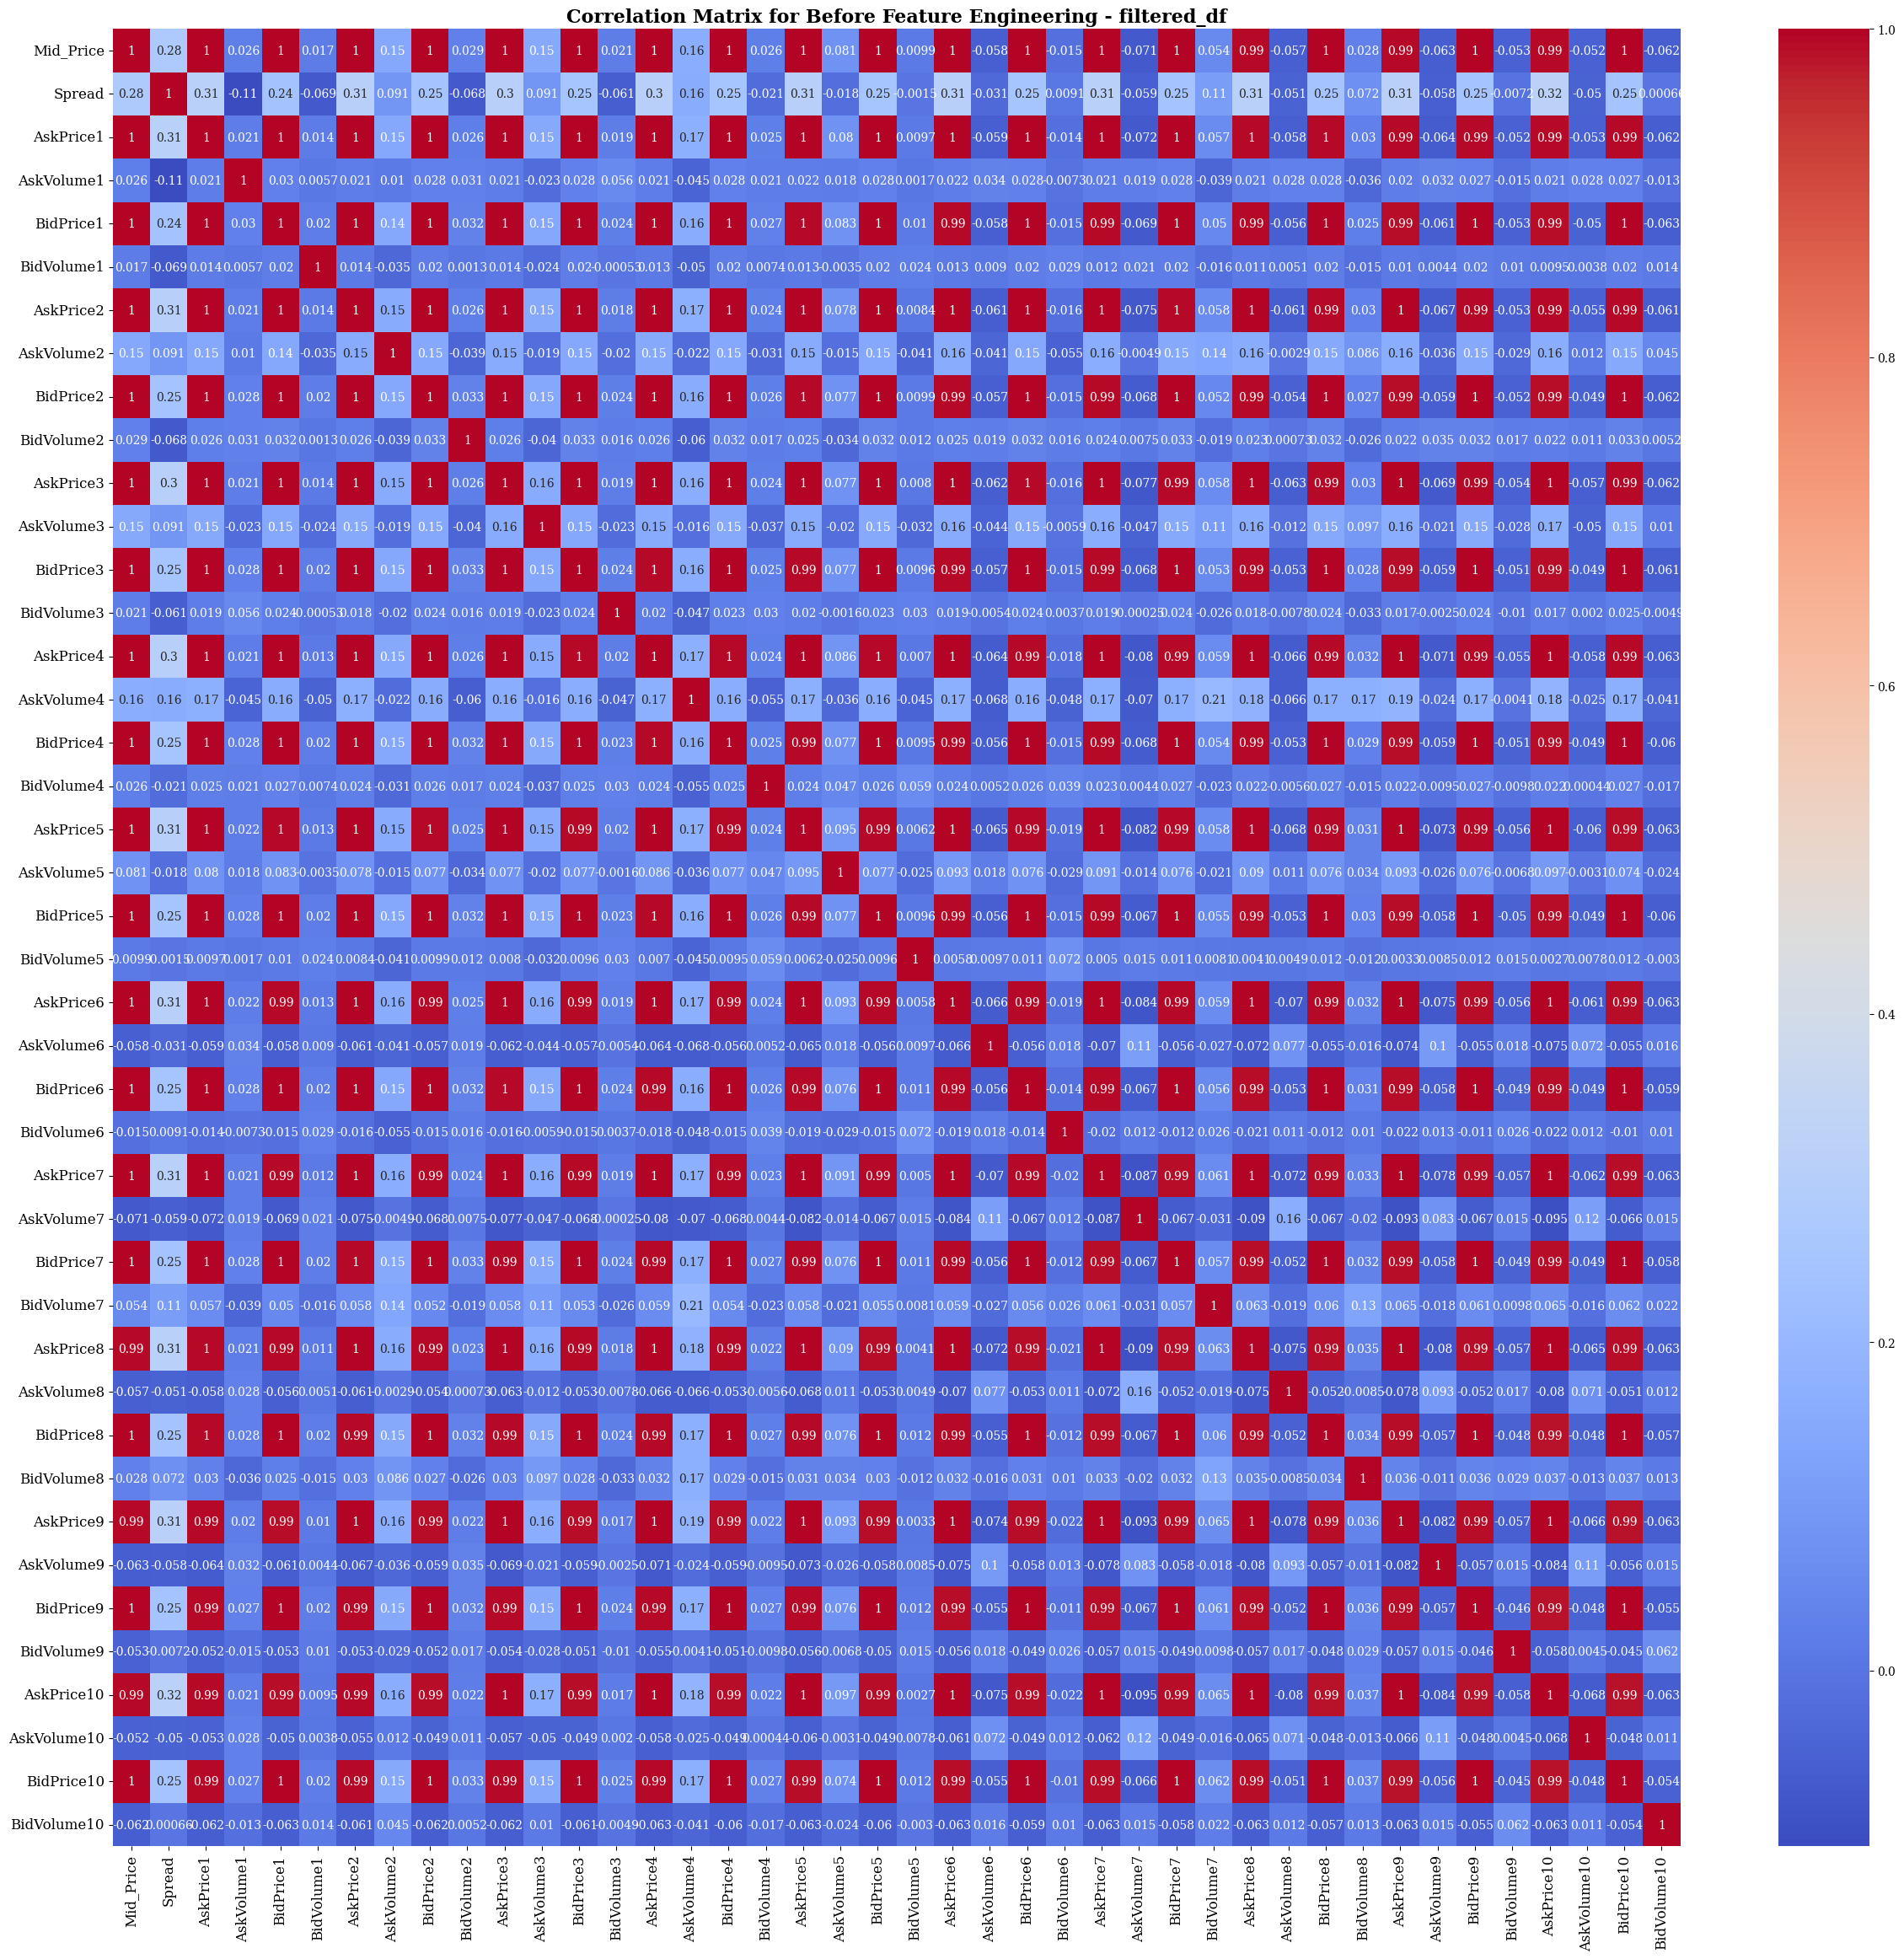

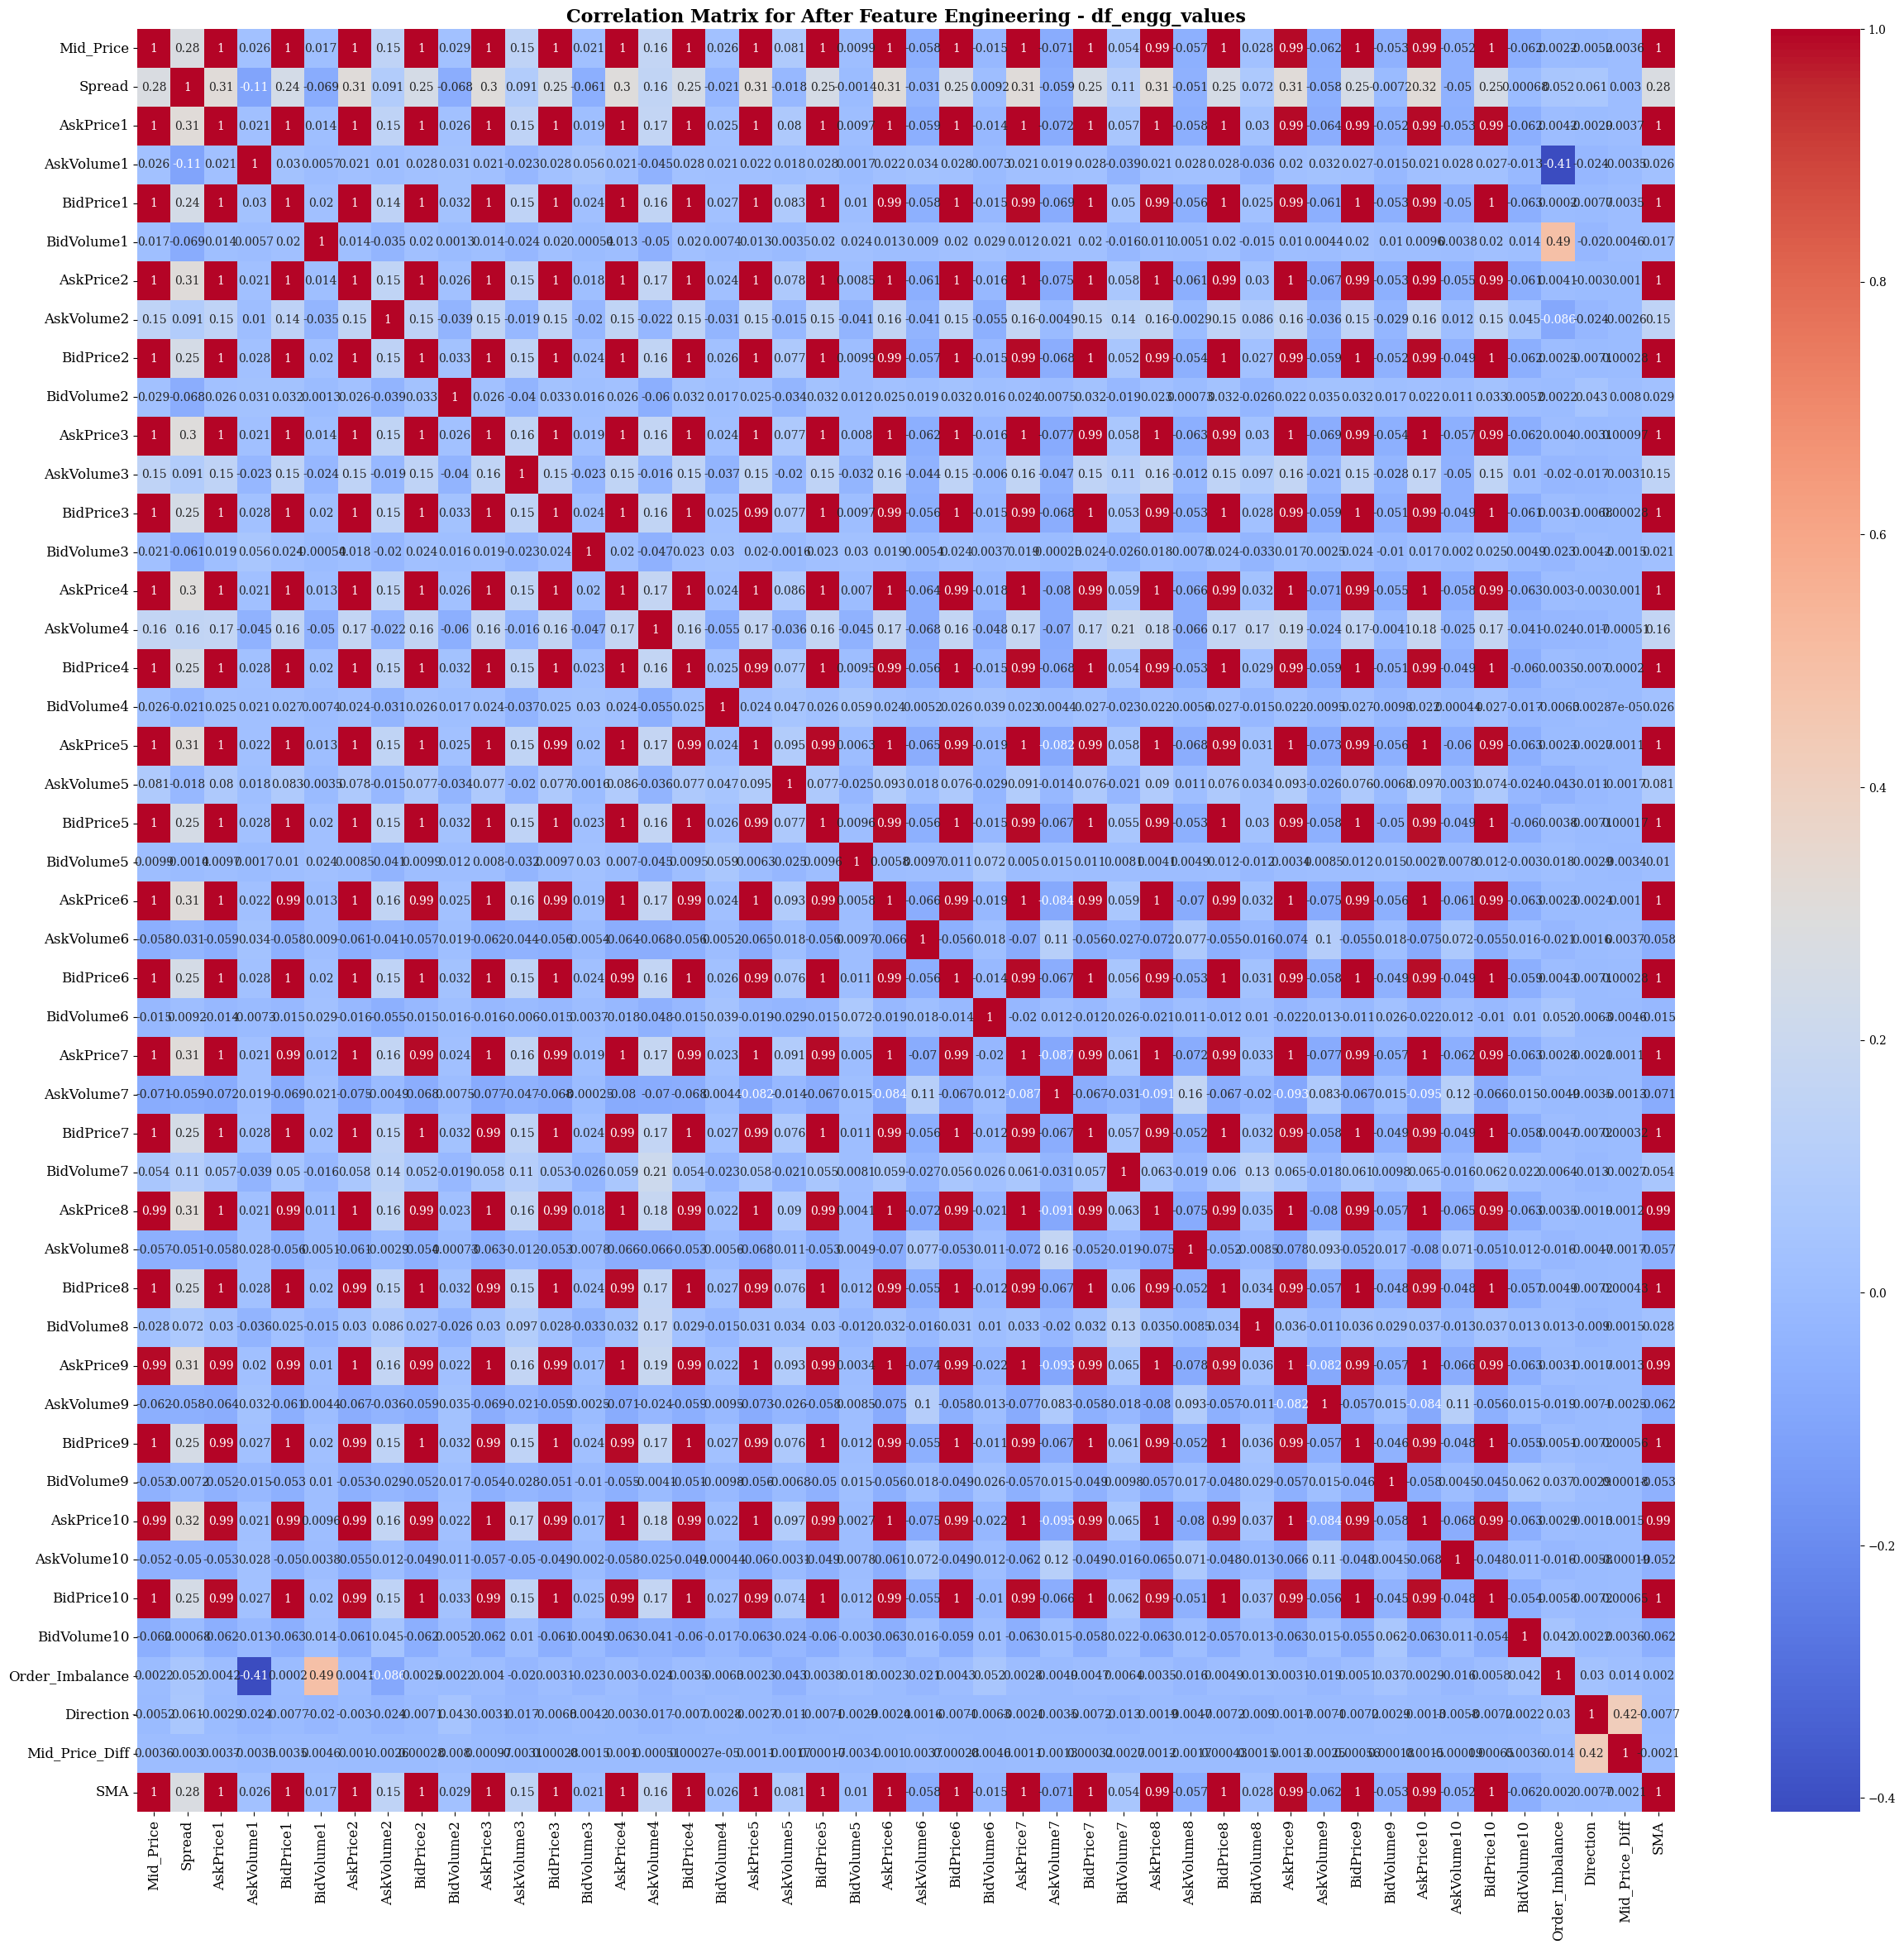

In [12]:

def corr_matrix_plot(df, title):
    """
    Plots the correlation matrix for a given dataframe.

    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe for which correlation matrix needs to be plotted.

    Returns:
    --------
    None
    """
    # Create correlation matrix subplot
    fig, ax = plt.subplots(figsize=(30, 28), dpi=100, nrows=1, ncols=1)
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=ax)

    # Add title and adjust font size and weight
    ax.set_title(f'Correlation Matrix for {title}', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

corr_matrix_plot(filtered_df, "Before Feature Engineering - filtered_df")
corr_matrix_plot(df_engg_values, "After Feature Engineering - df_engg_values")

In [13]:
def normalize_ftn(df):
    """
    Normalize the given pandas DataFrame using Z-score normalization.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame to be normalized
    
    Returns:
    --------
        data_mean : pandas Series
            Mean value of each column in the input DataFrame
        data_std : pandas Series
            Standard deviation of each column in the input DataFrame
        df_scaled : pandas DataFrame
            Normalized DataFrame with Z-score normalization applied
    """
    # Reference : https://www.statology.org/z-score-normalization/
    # Calculate mean and standard deviation for each column in the DataFrame
    data_mean = df.mean()
    data_std = df.std()
    
    # Normalize the DataFrame using Z-score normalization
    df_scaled = (df - data_mean) / data_std
    
    return data_mean, data_std, df_scaled

# Normalize the given DataFrame using Z-score normalization
data_mean, data_std, df_scaled = normalize_ftn(df_IndexChanged)

In [14]:
fontsize = 18
fontweight = 'bold'

In [15]:
def create_data_sequence_IO(data, look_back, horizon):
    """
    create_data_sequence_IO for time series forecasting using a sliding window approach.

    Parameters:
    -----------
    data : dataframe
        A dataframe of shape (n_samples, n_features).
    look_back : int
        The number of time steps to look back when creating input sequences.
    horizon : int
        The number of time steps to predict into the future.

    Returns:
    --------
    X : numpy array

    y : numpy array
    
    """
    X, y = [], []
    for i in range(len(data)-look_back-horizon+1):
        X.append(data[i:i+look_back, :])
        y.append(data[i+look_back:i+look_back+horizon, 0])
    return np.array(X), np.array(y)


In [16]:
def denormalize_ftn(data, data_std, data_mean):
    """
    Denormalizes the data using the previously calculated mean and standard deviation.

    Parameters:
    data (numpy array): Normalized data to be denormalized.

    Returns:
    numpy array: Denormalized data.
    """
    # Multiply normalized data with standard deviation of last column and add the mean of last column
    denormalized = (data * data_std) + data_mean
    return denormalized

In [17]:
def create_lstm_model(X_train, y_train, n_neurons, num_steps_in = 7 , num_steps_out = 1, features_n = df_scaled.shape[1], learning_rate=0.001, n_epoch=50, n_batch=64, dropout_rate=0.1, optimizer='adam'):
    """
    Creates an LSTM model for time series prediction.

    Args:
    - X_train (ndarray): numpy array representing the input training data.
    - y_train (ndarray): numpy array representing the output training data.
    - n_neurons (int): Number of neurons in the LSTM layers.
    - num_steps_in (int): Number of time steps used for input data. [look_back]
    - num_steps_out (int): Number of time steps to predict for the output. [horizon]
    - features_n (int): Number of features in the input data.
    - learning_rate (float): Learning rate for the optimizer. Default is 0.001.
    - n_epoch (int): Number of epochs to train the model. Default is 50.
    - n_batch (int): Batch size for training. Default is 64.
    - dropout_rate (float): Dropout rate for regularization. Default is 0.1.
    - optimizer (str): Name of the optimizer to use. Default is 'adam'.

    Returns:
    - model (LSTM model): The compiled LSTM model.

    """
    # create LSTM model
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(num_steps_in, features_n), return_sequences=True, activation='elu'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_neurons//2, return_sequences=True, activation='elu'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_neurons//4, activation='elu'))
    model.add(Dense(num_steps_out))
    model.add(Activation('linear'))

    # set optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError('Invalid optimizer specified')
    
    model.compile(optimizer = opt, loss='mse', metrics=['mae'])

    return model


In [18]:
# Set hyperparameters
look_back = 7
horizon = 1
n_neurons = 64
num_steps_in = look_back
num_steps_out = horizon
n_features = df_scaled.shape[1]
learning_rate = 0.001
n_epoch = 100
n_batch = 64
dropout_rate = 0.1
optimizer = 'adam'
val_split = 0.1
n_chunks = 2
n_features = df_scaled.shape[1]

In [19]:
def create_new_autoencoder(X_train_AE, look_back, n_features, compressed_dim, neurons):
    """
    Create a new autoencoder model with encoder and decoder parts, using LSTM layers.
    
    Args:
    - X_train_AE training data uncompressed
    - look_back (int): the number of time steps to look back
    - n_features (int): the number of features in the input data
    - compressed_dim (int): the number of dimensions in the compressed representation
    - neurons (int): the number of neurons in each LSTM layer
    
    Returns:
    - [Model, Model, EarlyStopping]: the autoencoder, encoder, and early stopping callback
    """
    
    # Define the input layer
    inputs = Input(shape=(look_back, n_features))

    # Define the encoder layers
    encoded = LSTM(neurons, activation = 'relu', return_sequences = True)(inputs)
    encoded = LSTM(neurons//2, activation = 'relu', return_sequences = False)(encoded)
    compressed = Dense(compressed_dim * look_back, activation = 'relu')(encoded)
    compressed = Reshape((look_back, compressed_dim))(compressed)

   # Create a new model that outputs the compressed layer
    encoder = Model(inputs, compressed)

    # Define the decoder layers
    decoded = LSTM(neurons//2, activation = 'relu', return_sequences = True)(compressed)
    decoded = LSTM(neurons, activation = 'relu', return_sequences = True)(decoded)
    decoded = Dense(n_features, activation = 'linear')(decoded)

    # Define the autoencoder model
    autoencoder = Model(inputs, decoded)


    # Compile the autoencoder model with the given loss function
    autoencoder.compile(optimizer = 'adam', loss = 'mse')


    # early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True)

    # Train the autoencoder
    autoencoder.fit( X_train_AE, X_train_AE, 
                     epochs = 100, batch_size = 32, 
                     validation_split = 0.1, callbacks = [es] )
 

    return autoencoder, encoder

In [20]:
def create_cnn_model(X_train, y_train, n_neurons, num_steps_in=look_back, num_steps_out=horizon, features_n=n_features, learning_rate=0.001, n_epoch=50, n_batch=64, dropout_rate=0.1, optimizer='adam'):
    """
    Creates a CNN model for time series prediction.

    Args:
    - X_train (ndarray): numpy array representing the input training data.
    - y_train (ndarray): numpy array representing the output training data.
    - n_filters (int): Number of filters in the convolutional layers.
    - filter_size (int): Size of the convolutional filters.
    - pool_size (int): Size of the pooling windows.
    - n_neurons (int): Number of neurons in the dense layers.
    - num_steps_in (int): Number of time steps used for input data. [look_back]
    - num_steps_out (int): Number of time steps to predict for the output. [horizon]
    - features_n (int): Number of features in the input data.
    - learning_rate (float): Learning rate for the optimizer. Default is 0.001.
    - n_epoch (int): Number of epochs to train the model. Default is 50.
    - n_batch (int): Batch size for training. Default is 64.
    - dropout_rate (float): Dropout rate for regularization. Default is 0.1.
    - optimizer (str): Name of the optimizer to use. Default is 'adam'.

    Returns:
    - model (CNN model): The compiled CNN model.

    """

    # n_filters = 64
    # filter_size = 2
    # pool_size = 2
    # create CNN model
    model = Sequential()
    model.add(Conv1D(64,  2, activation='relu', input_shape=(num_steps_in, features_n)))
    model.add(MaxPooling1D( 2))
    model.add(Conv1D( 64, 2, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(n_neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons//2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons//4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_steps_out))
    model.add(Activation('linear'))

    # set optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError('Invalid optimizer specified')
    
    model.compile(optimizer = opt, loss='mse', metrics=['mae'])

    return model


In [21]:
def plot_metrics(history, title_label):
    """
    Plot the training and validation metrics over the epochs.

    Parameters:
        history (keras.callbacks.History): A Keras History object containing the training and validation metrics.
        title_label (str): A string that will be included in the title of the plot.

    Returns:
        None
    """
    # Plot the training and validation loss over the epochs
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    # Plot the training and validation MAE over the epochs
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')

    # Add a title to the plot using the title_label argument
    plt.title(f'Training and Validation Metrics - {title_label}')

    # Label the x- and y-axes
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')

    # Add a legend to the plot
    plt.legend()

    # Display the plot
    plt.show()

In [22]:
def plot_predictions(model, history, X_test, y_test, title):
    """
    This function generates and plots the predicted and actual values for the test set,
    along with the test loss and validation loss.

    Parameters:
        model (keras.Model): The trained LSTM model.
        X_test (numpy.ndarray): The input sequences for the test set.
        y_test (numpy.ndarray): The output sequences for the test set.
        title (str): The title of the plot.

    Returns:
        None.
    """
    # Generate predictions for the test set
    y_pred = model.predict(X_test)

    results = model.evaluate(X_test, y_test)
    # Calculate test loss and validation loss
    test_loss, test_mae = model.evaluate(X_test, y_test)
    val_loss = np.mean(history.history['val_loss'])
    # Calculate the mean by rows
    y_test = np.mean(y_test, axis=1)
    y_pred = np.mean(y_pred, axis=1)

    # Plot actual and predicted values
    fig, ax = plt.subplots(figsize=(20, 7))
    ax.plot(denormalize_ftn(y_test, data_std[0], data_mean[0]), label='Actual', color='blue')
    ax.plot(denormalize_ftn(y_pred, data_std[0], data_mean[0]), label='Predicted', linestyle='--', color='red')

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    # Add test loss and validation loss to plot
    ax.annotate(f'Test Loss: {test_loss:.5f}   Test RMSE: {rmse:.5f} \nValidation Loss: {val_loss:.5f}  Test MAE: {test_mae:.5f}\n MSE: {mse:.5f}', 
                 xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12)
    print(f'Test Loss: {test_loss:.5f}   Test RMSE: {rmse:.5f} \nValidation Loss: {val_loss:.5f}  Test MAE: {test_mae:.5f} MSE: {mse:.5f}')
    print(f'Results from model evaluate: {results}')
    # Add legend and labels
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Mid Price')
    plt.title(f'Actual vs. Predicted Values for {title}')

    plt.show()


In [59]:
def plot_predictions_dual(model, X_test, y_test, title):
    # Predict the outputs for the test input
    y_pred_clf, y_pred_reg = model.predict(X_test)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    # Plot the predicted and actual outputs for the classification task
    ax1.plot(y_test[:, 0], label='True values')
    ax1.plot(y_pred_clf[:, 0], label='Predicted values')
    ax1.set_title(f"{title} - Classification Task")
    ax1.legend()

    # Plot the predicted and actual outputs for the regression task
    ax2.plot(y_test[:, 0], label='True values')
    ax2.plot(y_pred_reg[:, 0], label='Predicted values')
    ax2.set_title(f"{title} - Regression Task")
    ax2.legend()

    # Show the plot
    plt.show()


In [24]:
def train_model(X_train, y_train, X_test, y_test, model, n_batch=64, n_epochs=50, val_split=0.1):
    """
    This function trains an LSTM model and returns the trained model and training history.

    Parameters:
        X_train (numpy.ndarray): The input sequences for the training set.
        y_train (numpy.ndarray): The output sequences for the training set.
        X_test (numpy.ndarray): The input sequences for the test set.
        y_test (numpy.ndarray): The output sequences for the test set.
        model (keras.Model): The LSTM model to be trained.
        n_batch (int): The batch size to be used for training.
        n_epochs (int): The number of epochs to be used for training.
        val_split (float): The fraction of the training set to be used as validation data.

    Returns:
        history (keras.callbacks.History): The training history.
        model (keras.Model): The trained LSTM model.
    """

    # define early stopping criteria
    earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 16, verbose = 1, mode = 'auto', restore_best_weights = True)

    history = model.fit(X_train, y_train, batch_size=n_batch, epochs=n_epochs, validation_split=val_split, callbacks=[earlystop])

    # Evaluate model on test data
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'\nTest Loss: {test_loss:.5f}, Test MAE: {test_mae:.5f}\n')

    return history, model

In [26]:
# n_neurons = n_neurons_best 
# dropout_rate = dropout_rate_best 
# learning_rate = learning_rate_best 

# >45 features - Some have moderate to High degree of correlation with Mid_Price
# 20 reduced dimensions - Ideally, compressed dimensions can be 22/23 - 24 is quite reasonable 
# Extracted Features can give a lot of information


train_data, test_data = train_test_split(df_scaled, test_size=0.2, shuffle=False)

# Create input-output pairs for autoencoder
X_train_ae, y_train_ae = create_data_sequence_IO(train_data.values, 
                                                   look_back = look_back, 
                                                   horizon   = horizon)

X_test_ae, y_test_ae = create_data_sequence_IO(test_data.values, 
                                                 look_back = look_back, 
                                                 horizon   = horizon)

# Create a new autoencoder model
new_autoencoder, new_encoder = create_new_autoencoder(X_train_ae, look_back = 7, 
                                                          n_features = df_scaled.shape[1], 
                                                          compressed_dim = 20, 
                                                          neurons = n_neurons)


# Use the encoder to transform the input data to the compressed form (extracted features)
compressed_X_train = new_encoder.predict(X_train_ae)
compressed_X_test = new_encoder.predict(X_test_ae)

Epoch 1/100
2122/2122 [==============================] - 62s 26ms/step - loss: 0.4546 - val_loss: 0.2060
Epoch 2/100
2122/2122 [==============================] - 57s 27ms/step - loss: 0.3150 - val_loss: 0.1838
Epoch 3/100
2122/2122 [==============================] - 69s 32ms/step - loss: 0.2615 - val_loss: 0.1558
Epoch 4/100
2122/2122 [==============================] - 77s 36ms/step - loss: 0.2382 - val_loss: 0.1522
Epoch 5/100
2122/2122 [==============================] - 55s 26ms/step - loss: 0.2246 - val_loss: 0.1441
Epoch 6/100
2122/2122 [==============================] - 58s 27ms/step - loss: 0.2150 - val_loss: 0.1415
Epoch 7/100
2122/2122 [==============================] - 57s 27ms/step - loss: 0.2067 - val_loss: 0.1498
Epoch 8/100
2122/2122 [==============================] - 53s 25ms/step - loss: 0.1990 - val_loss: 0.1339
Epoch 9/100
2122/2122 [==============================] - 56s 26ms/step - loss: 0.1914 - val_loss: 0.1399
Epoch 10/100
2122/2122 [==============================]

In [27]:
# split the data into training and testing sets
train_data, test_data = train_test_split(df_scaled, test_size=0.2, shuffle=False)


X_train_mod, y_train_mod = create_data_sequence_IO(train_data.values, 
                                                             look_back, horizon)
X_test_mod, y_test_mod = create_data_sequence_IO(test_data.values, 
                                                           look_back, horizon)

# concat the extracted features and raw train-test sets of model (3-d shape - hence axis = 2)
concat_X_train = np.concatenate((X_train_mod, compressed_X_train), axis=2)

concat_X_test = np.concatenate((X_test_mod, compressed_X_test), axis=2)



In [28]:
# The seperators to split//slice 
seperator_train = len(concat_X_train)//2
seperator_train
seperator_test = len(concat_X_test)//2
seperator_test

9428

In [29]:
# First half  data

concat_X_train_1stHalf = concat_X_train[:seperator_train]
concat_X_test_1stHalf = concat_X_test[:seperator_test]
y_train_1stHalf = y_train_mod[:seperator_train]
y_test_1stHalf = y_test_mod[:seperator_test]
concat_X_train_1stHalf.shape

# second half  data
concat_X_train_2ndHalf = concat_X_train[seperator_train:]
concat_X_test_2ndHalf = concat_X_test[seperator_test:]
y_train_2ndHalf = y_train_mod[seperator_train:]
y_test_2ndHalf = y_test_mod[seperator_test:]


In [30]:
n_features = concat_X_train.shape[2]
# Create LSTM model
model_LSTM = create_lstm_model(concat_X_train_1stHalf, y_train_1stHalf, n_neurons, 
                          num_steps_in, num_steps_out, n_features, learning_rate, 
                          n_epoch, n_batch, dropout_rate, optimizer)

model_CNN = create_cnn_model(concat_X_train_1stHalf, y_train_1stHalf, n_neurons, 
                          num_steps_in, num_steps_out, n_features, learning_rate, 
                          n_epoch, n_batch, dropout_rate, optimizer)

Epoch 1/100
531/531 [==============================] - 19s 27ms/step - loss: 0.0254 - mae: 0.0840 - val_loss: 0.0065 - val_mae: 0.0647
Epoch 2/100
531/531 [==============================] - 13s 25ms/step - loss: 0.0049 - mae: 0.0487 - val_loss: 0.0185 - val_mae: 0.1114
Epoch 3/100
531/531 [==============================] - 11s 21ms/step - loss: 0.0035 - mae: 0.0418 - val_loss: 0.0488 - val_mae: 0.1874
Epoch 4/100
531/531 [==============================] - 13s 24ms/step - loss: 0.0027 - mae: 0.0371 - val_loss: 0.0263 - val_mae: 0.1268
Epoch 5/100
531/531 [==============================] - 13s 25ms/step - loss: 0.0023 - mae: 0.0341 - val_loss: 0.0131 - val_mae: 0.0971
Epoch 6/100
531/531 [==============================] - 14s 26ms/step - loss: 0.0022 - mae: 0.0335 - val_loss: 0.0212 - val_mae: 0.1249
Epoch 7/100
531/531 [==============================] - 12s 23ms/step - loss: 0.0019 - mae: 0.0309 - val_loss: 0.0115 - val_mae: 0.0905
Epoch 8/100
531/531 [==============================] - 

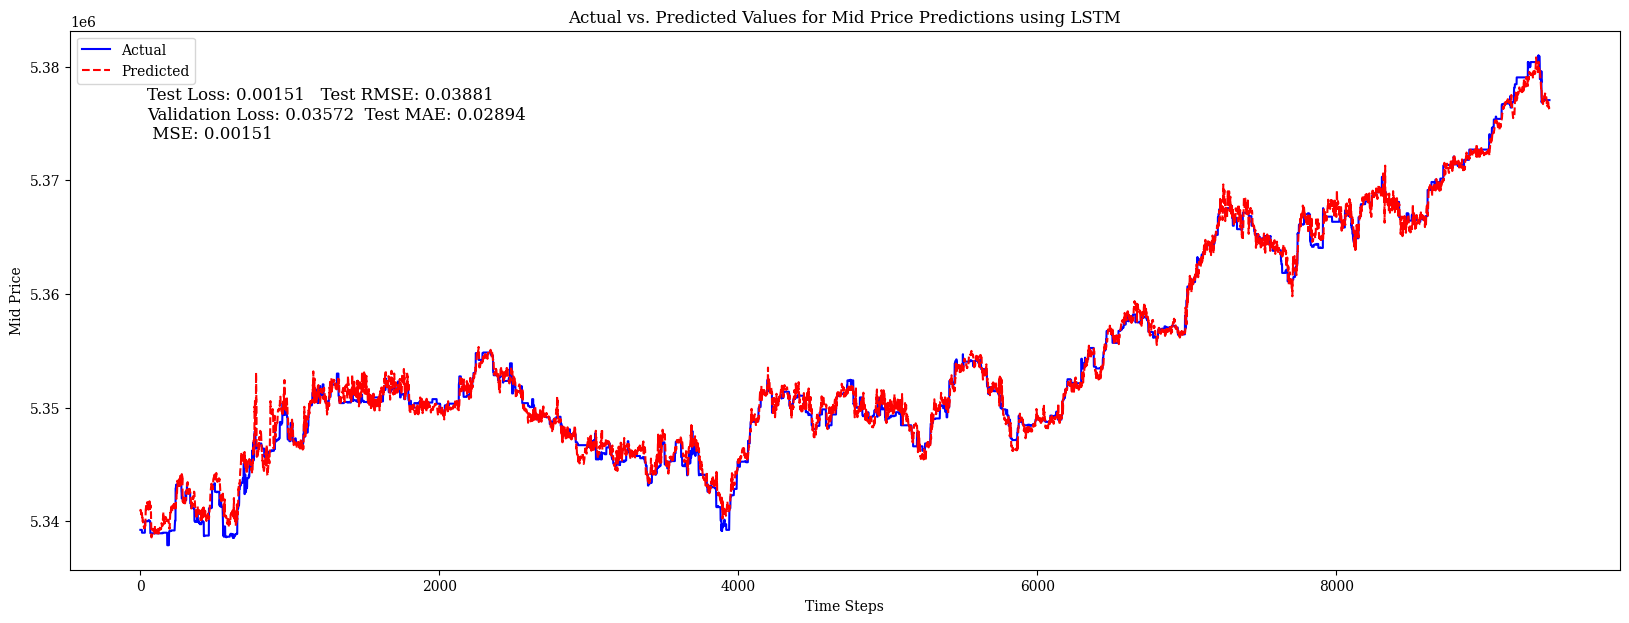

Epoch 1/100
531/531 [==============================] - 5s 7ms/step - loss: 0.1179 - mae: 0.2101 - val_loss: 0.0112 - val_mae: 0.0986
Epoch 2/100
531/531 [==============================] - 4s 8ms/step - loss: 0.0423 - mae: 0.1352 - val_loss: 0.0580 - val_mae: 0.2369
Epoch 3/100
531/531 [==============================] - 5s 10ms/step - loss: 0.0353 - mae: 0.1247 - val_loss: 0.0449 - val_mae: 0.2079
Epoch 4/100
531/531 [==============================] - 4s 7ms/step - loss: 0.0319 - mae: 0.1192 - val_loss: 0.0584 - val_mae: 0.2375
Epoch 5/100
531/531 [==============================] - 4s 7ms/step - loss: 0.0299 - mae: 0.1166 - val_loss: 0.0460 - val_mae: 0.2104
Epoch 6/100
531/531 [==============================] - 4s 8ms/step - loss: 0.0289 - mae: 0.1156 - val_loss: 0.1032 - val_mae: 0.3174
Epoch 7/100
531/531 [==============================] - 5s 10ms/step - loss: 0.0272 - mae: 0.1139 - val_loss: 0.0725 - val_mae: 0.2661
Epoch 8/100
531/531 [==============================] - 4s 7ms/step 

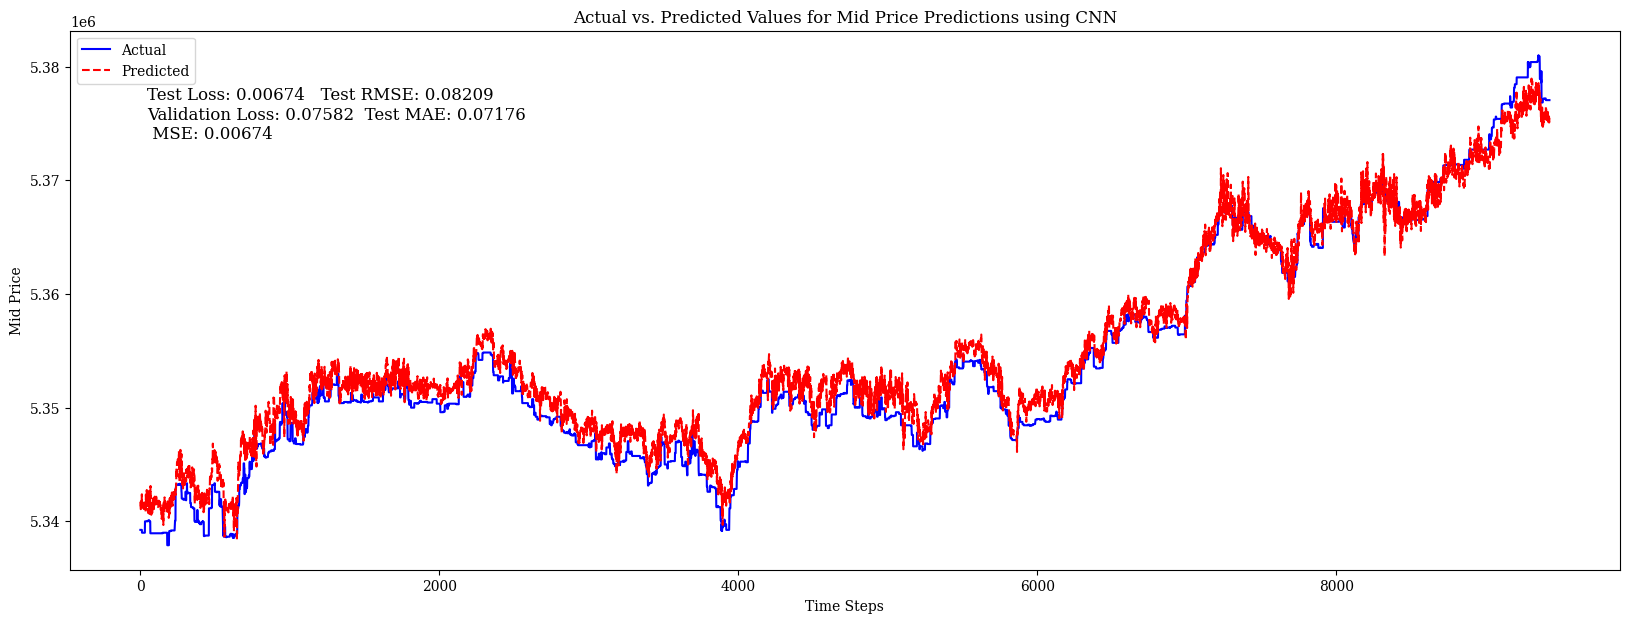

In [31]:

# Train LSTM model on initial data - 1st half
history_LSTM_, model_LSTM_ = train_model(concat_X_train_1stHalf, y_train_1stHalf, concat_X_test_1stHalf, y_test_1stHalf, 
                             model_LSTM, n_batch, n_epoch, val_split)

# Preduct and Plot values
plot_predictions(model_LSTM_, history_LSTM_, concat_X_test_1stHalf, y_test_1stHalf, "Mid Price Predictions using LSTM")

# Train CNN model on same data
history_CNN_ , model_CNN_ = train_model(concat_X_train_1stHalf, y_train_1stHalf, concat_X_test_1stHalf, y_test_1stHalf, 
                             model_CNN, n_batch, n_epoch, val_split)


plot_predictions(model_CNN_, history_CNN_, concat_X_test_1stHalf, y_test_1stHalf, "Mid Price Predictions using CNN")


In [32]:
# Save the models for future refernce
model_LSTM_.save('lstm_model.h5')
model_CNN_.save('CNN_model.h5')

In [33]:
# Define the number of chunks to split the data into
n_chunks = 3

# Determine the size of each chunk
chunk_size_trn = len(concat_X_train_2ndHalf) // (n_chunks)
chunk_size_tst = len(concat_X_test_2ndHalf) // (n_chunks)


# Split the data into chunks
X_train_data_chunks = [concat_X_train_2ndHalf[i:i+chunk_size_trn] for i in range(0, len(concat_X_train_2ndHalf), chunk_size_trn)]

X_test_data_chunks = [concat_X_test_2ndHalf[i:i+chunk_size_tst] for i in range(0, len(concat_X_test_2ndHalf), chunk_size_tst)]

y_train_data_chunks = [y_train_2ndHalf[i:i+chunk_size_trn] for i in range(0, len(y_train_2ndHalf), chunk_size_trn)]


y_test_data_chunks = [y_test_2ndHalf[i:i+chunk_size_tst] for i in range(0, len(y_test_2ndHalf), chunk_size_tst)]

# Load the saved models
model_LSTM_chunked = load_model('lstm_model.h5')
model_CNN_chunked = load_model('CNN_model.h5')



Epoch 1/100
177/177 [==============================] - 12s 48ms/step - loss: 0.0022 - mae: 0.0343 - val_loss: 5.3067e-04 - val_mae: 0.0178
Epoch 2/100
177/177 [==============================] - 4s 21ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 4.4257e-04 - val_mae: 0.0166
Epoch 3/100
177/177 [==============================] - 4s 21ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 4.4995e-04 - val_mae: 0.0168
Epoch 4/100
177/177 [==============================] - 6s 34ms/step - loss: 8.7515e-04 - mae: 0.0223 - val_loss: 3.1189e-04 - val_mae: 0.0129
Epoch 5/100
177/177 [==============================] - 4s 21ms/step - loss: 8.1942e-04 - mae: 0.0216 - val_loss: 2.7764e-04 - val_mae: 0.0121
Epoch 6/100
177/177 [==============================] - 4s 20ms/step - loss: 7.6975e-04 - mae: 0.0207 - val_loss: 3.3700e-04 - val_mae: 0.0134
Epoch 7/100
177/177 [==============================] - 4s 21ms/step - loss: 7.3907e-04 - mae: 0.0203 - val_loss: 3.7650e-04 - val_mae: 0.0146
Epoch 8/100
177/1

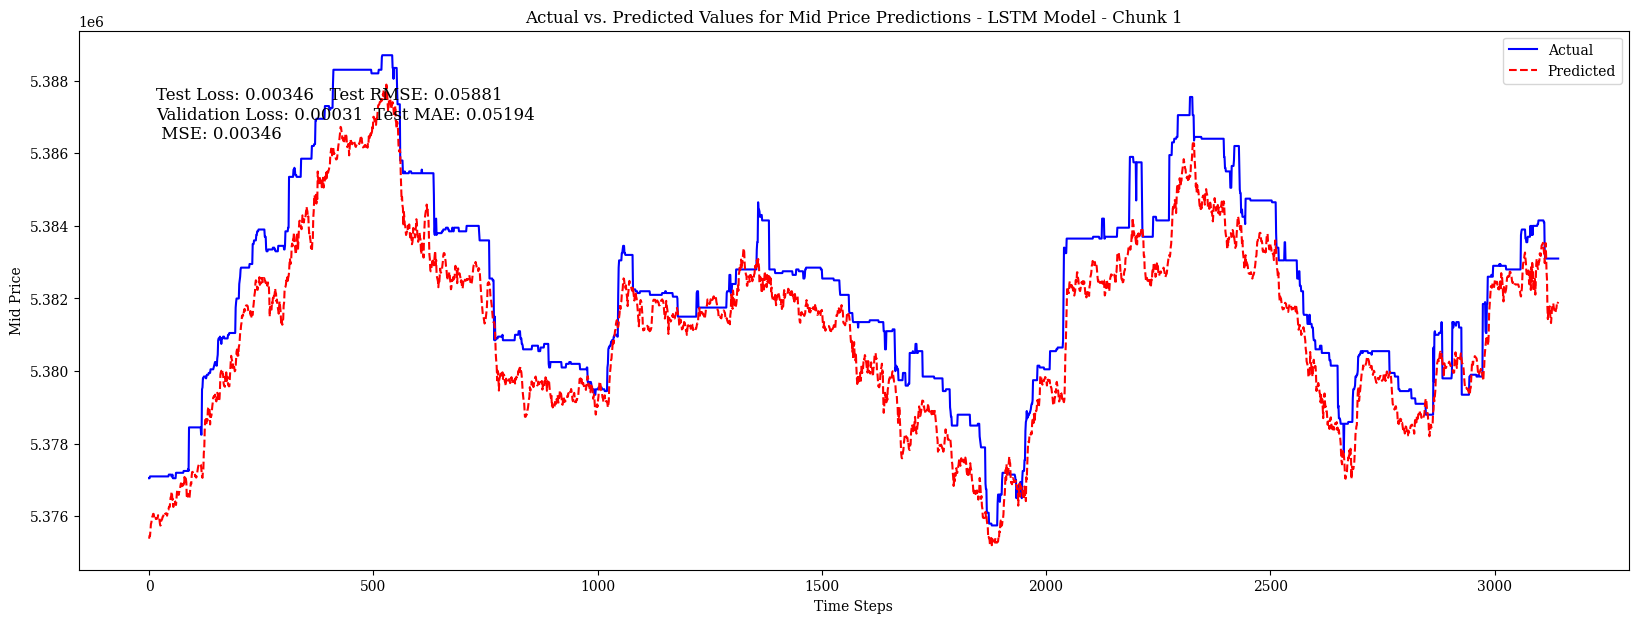

99/99 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.2388
Test Loss: 0.05908   Test RMSE: 0.24306 
Validation Loss: 0.00073  Test MAE: 0.23879 MSE: 0.05908
Results from model evaluate: [0.059076517820358276, 0.23878727853298187]


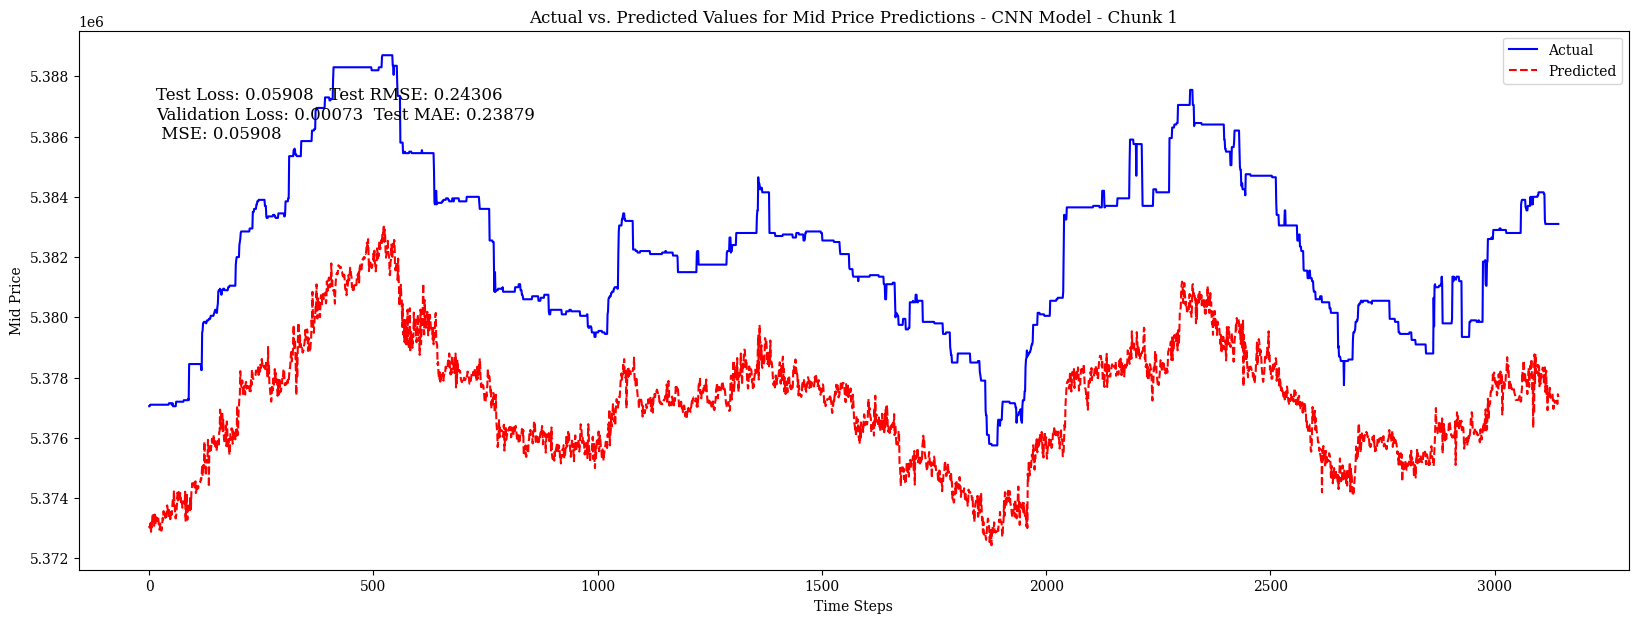

Epoch 1/100
177/177 [==============================] - 4s 23ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 8.1679e-04 - val_mae: 0.0216
Epoch 2/100
177/177 [==============================] - 6s 32ms/step - loss: 8.8267e-04 - mae: 0.0225 - val_loss: 9.1788e-04 - val_mae: 0.0225
Epoch 3/100
177/177 [==============================] - 5s 28ms/step - loss: 7.2622e-04 - mae: 0.0201 - val_loss: 8.3758e-04 - val_mae: 0.0218
Epoch 4/100
177/177 [==============================] - 4s 23ms/step - loss: 6.7944e-04 - mae: 0.0194 - val_loss: 8.9197e-04 - val_mae: 0.0224
Epoch 5/100
177/177 [==============================] - 4s 22ms/step - loss: 6.5660e-04 - mae: 0.0192 - val_loss: 8.8708e-04 - val_mae: 0.0238
Epoch 6/100
177/177 [==============================] - 6s 36ms/step - loss: 6.3023e-04 - mae: 0.0187 - val_loss: 6.7579e-04 - val_mae: 0.0205
Epoch 7/100
177/177 [==============================] - 4s 24ms/step - loss: 5.4747e-04 - mae: 0.0174 - val_loss: 6.7030e-04 - val_mae: 0.0196
Epoch 8/10

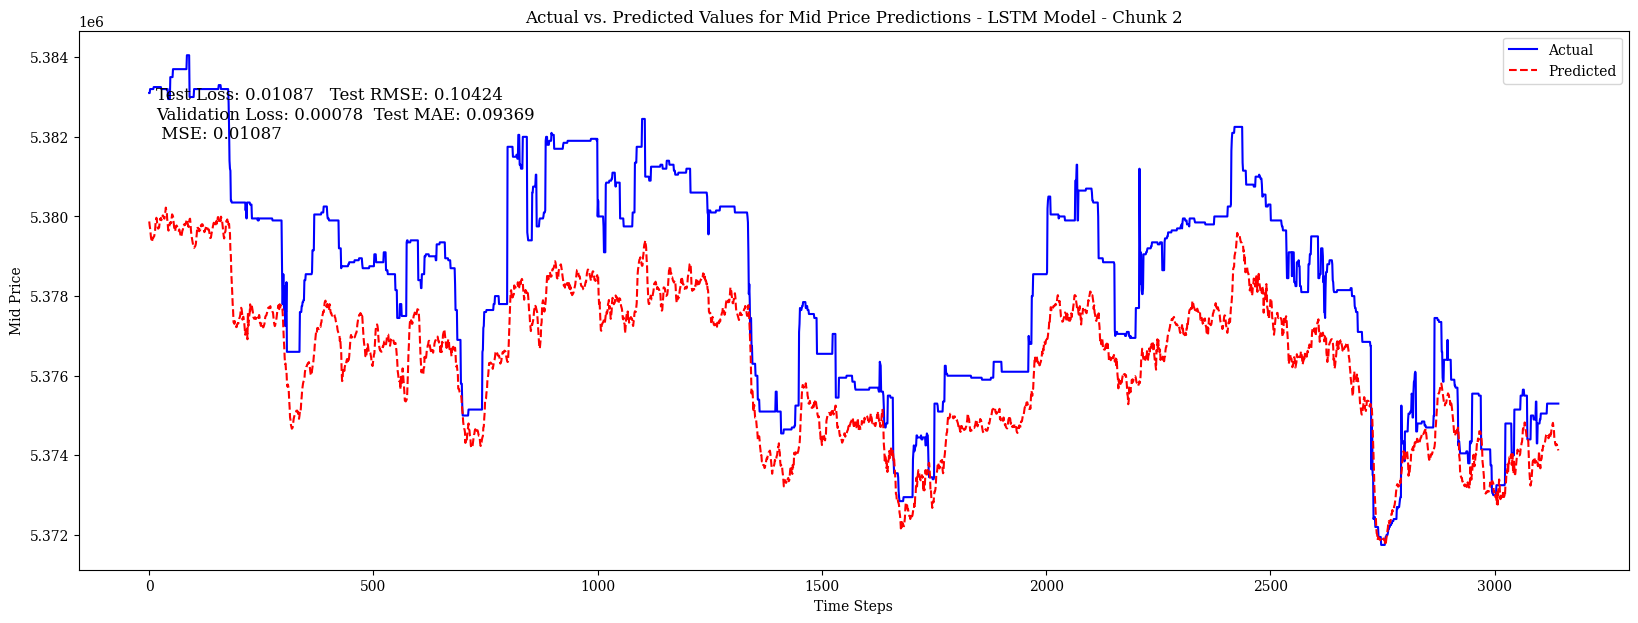

99/99 [==============================] - 0s 3ms/step - loss: 0.0365 - mae: 0.1855
Test Loss: 0.03655   Test RMSE: 0.19117 
Validation Loss: 0.00693  Test MAE: 0.18549 MSE: 0.03655
Results from model evaluate: [0.03654748201370239, 0.18548661470413208]


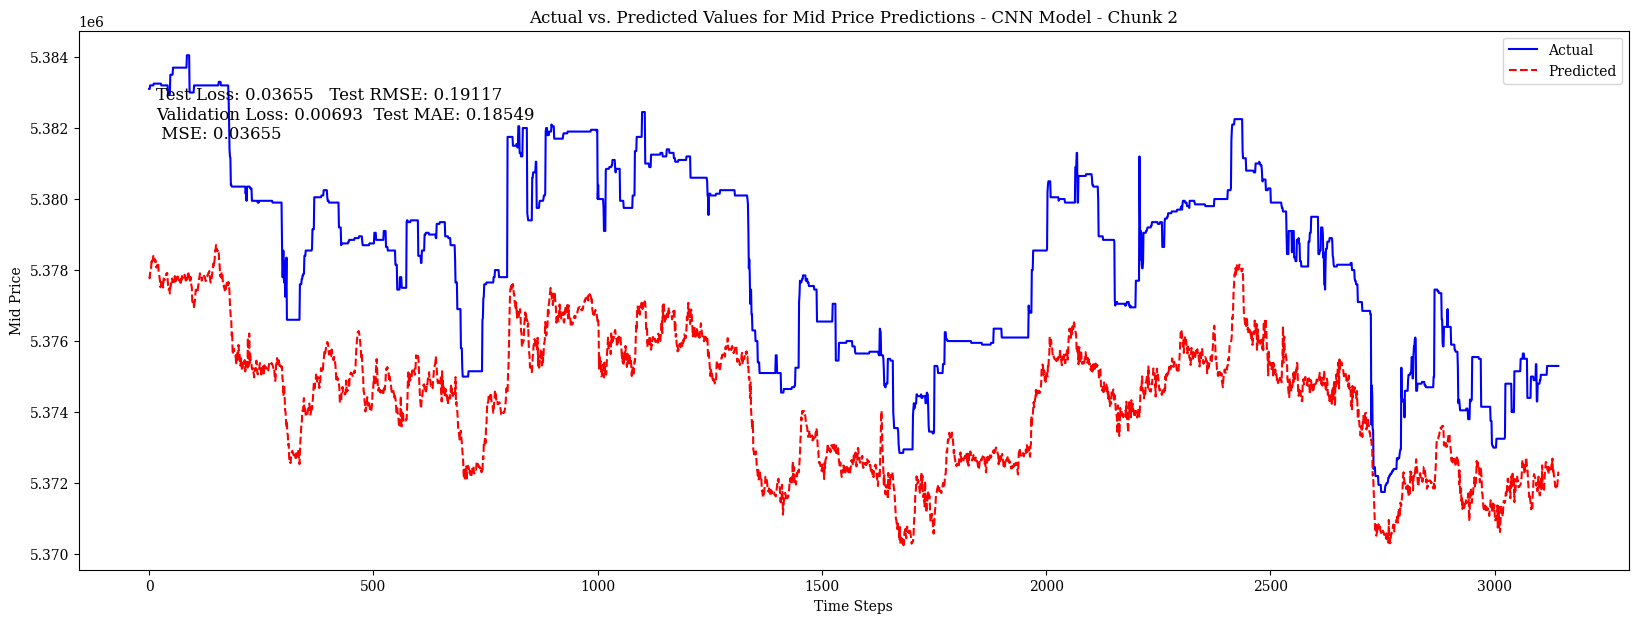

Epoch 1/100
177/177 [==============================] - 5s 28ms/step - loss: 0.0170 - mae: 0.0693 - val_loss: 9.9503e-04 - val_mae: 0.0229
Epoch 2/100
177/177 [==============================] - 6s 35ms/step - loss: 0.0023 - mae: 0.0368 - val_loss: 8.8112e-04 - val_mae: 0.0214
Epoch 3/100
177/177 [==============================] - 4s 22ms/step - loss: 0.0018 - mae: 0.0331 - val_loss: 9.6975e-04 - val_mae: 0.0215
Epoch 4/100
177/177 [==============================] - 4s 23ms/step - loss: 0.0015 - mae: 0.0301 - val_loss: 6.7631e-04 - val_mae: 0.0183
Epoch 5/100
177/177 [==============================] - 5s 30ms/step - loss: 0.0013 - mae: 0.0281 - val_loss: 7.0317e-04 - val_mae: 0.0186
Epoch 6/100
177/177 [==============================] - 6s 33ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 7.2245e-04 - val_mae: 0.0191
Epoch 7/100
177/177 [==============================] - 4s 23ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 6.2639e-04 - val_mae: 0.0169
Epoch 8/100
177/177 [=============

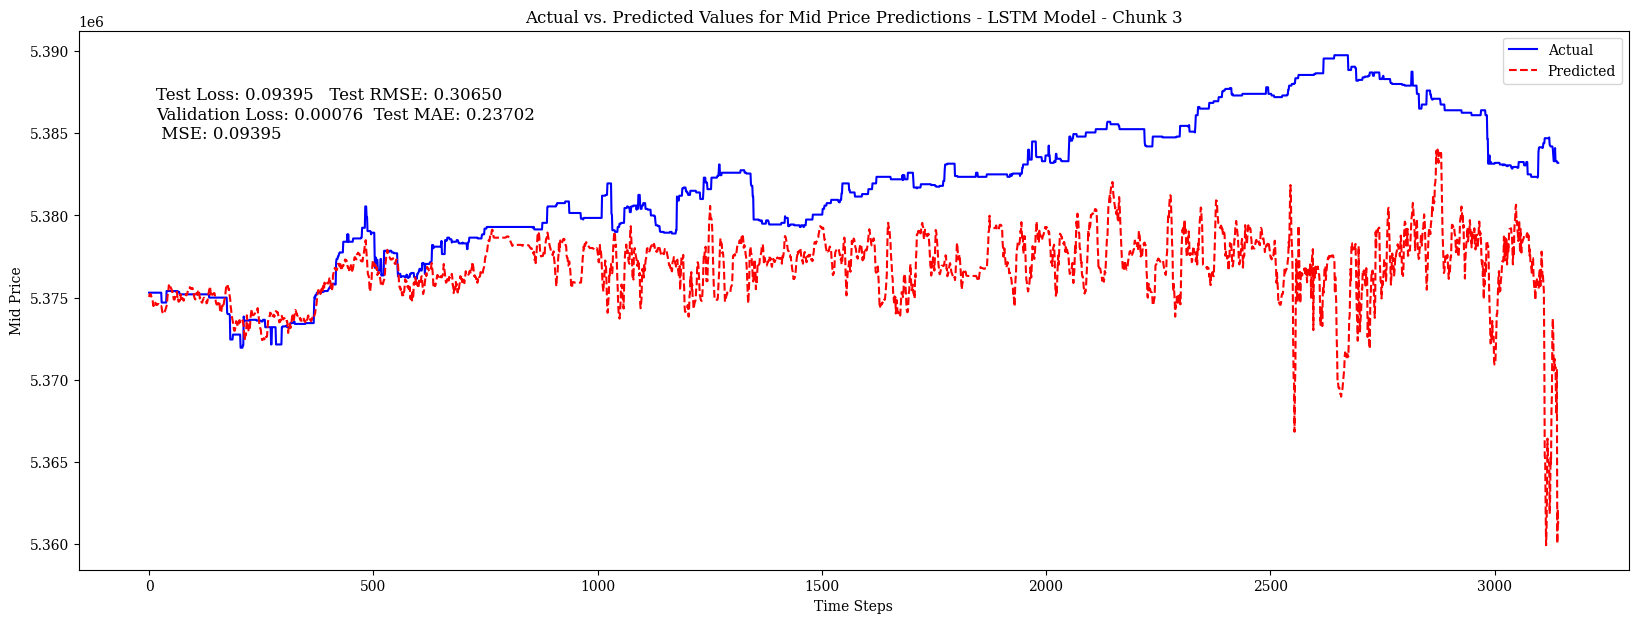

99/99 [==============================] - 0s 3ms/step - loss: 0.0471 - mae: 0.2082
Test Loss: 0.04715   Test RMSE: 0.21713 
Validation Loss: 0.00235  Test MAE: 0.20824 MSE: 0.04715
Results from model evaluate: [0.047146763652563095, 0.2082444727420807]


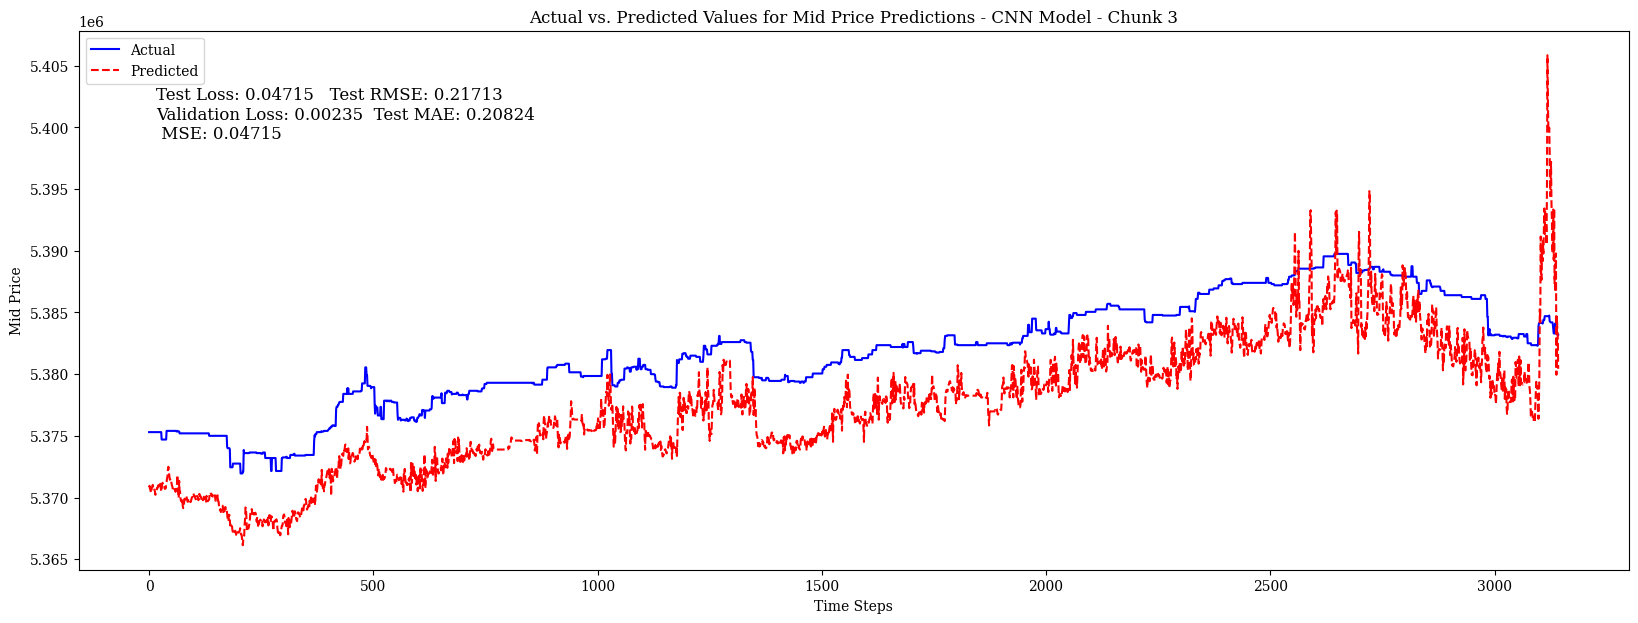

In [34]:
# Loop through the chunks and train the models on the new data
for i in range(n_chunks):
    # Get the new data
    X_new_data_train = X_train_data_chunks[i]
    
    X_new_data_test = X_test_data_chunks[i] if i < len(X_train_data_chunks) else X_test_data_chunks[-1]
    y_new_data_train = y_train_data_chunks[i]
    y_new_data_test = y_test_data_chunks[i] if i < len(y_train_data_chunks) else y_test_data_chunks[-1]

    # Train the models on the new data
    history_LSTM_chunked, model_LSTM_chunked = train_model(X_new_data_train, y_new_data_train, X_new_data_test, y_new_data_test, 
                                                         model_LSTM_chunked, n_batch, n_epoch, val_split)
    history_CNN_chunked, model_CNN_chunked = train_model(X_new_data_train, y_new_data_train, X_new_data_test, y_new_data_test, 
                                                         model_CNN_chunked, n_batch, n_epoch, val_split)
    
    # Plot the predictions for the new data
    plot_predictions(model_LSTM_chunked, history_LSTM_chunked, X_new_data_test, y_new_data_test, f"Mid Price Predictions - LSTM Model - Chunk {i+1}")
    plot_predictions(model_CNN_chunked, history_CNN_chunked, X_new_data_test, y_new_data_test, f"Mid Price Predictions - CNN Model - Chunk {i+1}")

    # Save the models after each chunk is trained
    model_LSTM_chunked.save('lstm_model.h5')
    model_CNN_chunked.save('CNN_model.h5')


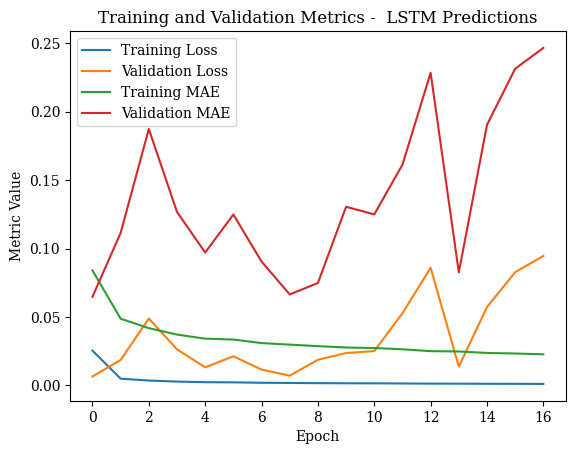

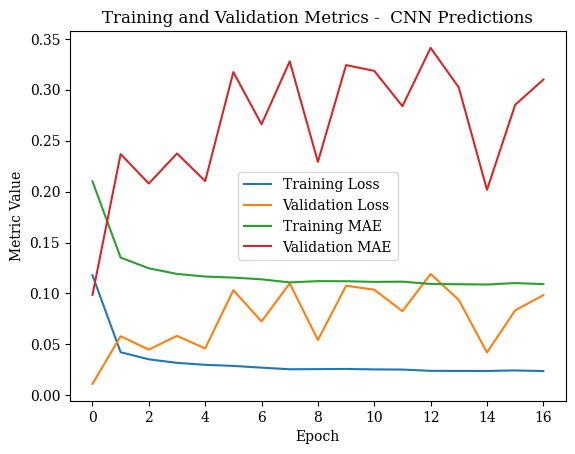

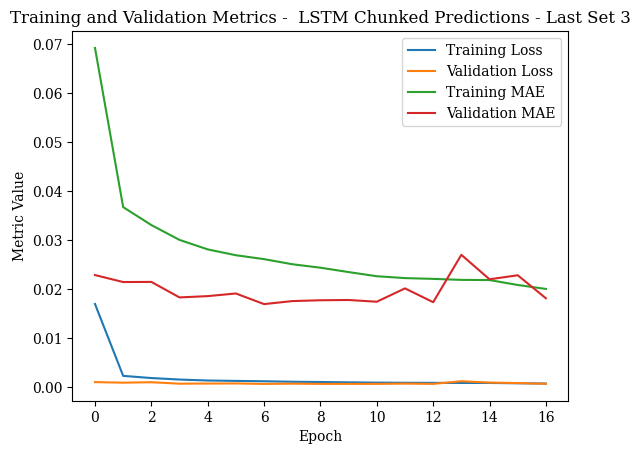

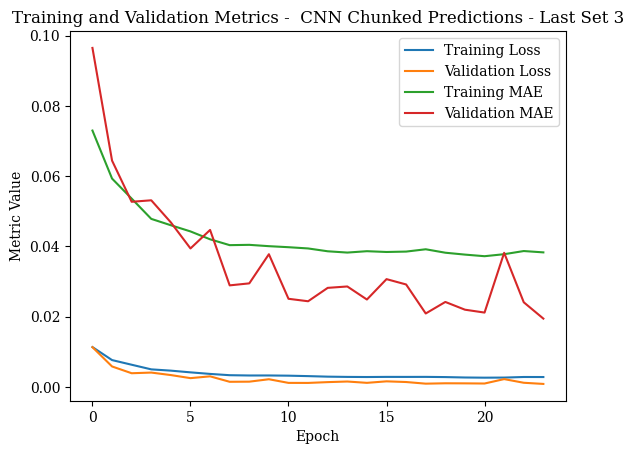

In [36]:
plot_metrics(history_LSTM_, " LSTM Predictions")
plot_metrics(history_CNN_, " CNN Predictions")
plot_metrics(history_LSTM_chunked, " LSTM Chunked Predictions - Last Set 3")
plot_metrics(history_CNN_chunked, " CNN Chunked Predictions - Last Set 3")


In [43]:
new_autoencoder.save("LSTM_AutoEncoder.h5")


In [40]:
def print_model_losses(history, title):
    test_loss = history.history['val_loss'][-1]
    test_mse = np.mean(history.history['val_loss'])
    mae = np.mean(history.history['mae'])
    if 'mse' in history.history:
        mse = history.history['mse']
        rmse = [np.sqrt(m) for m in mse]
        print(f"\n Loss Metrics for {title}:\n")
        print(f"Test Loss: {test_loss:.6f}")
        print(f"Test MSE: {test_mse:.6f}")
        print(f"Mean Absolute Error: {mae:.6f}")
        print(f"Mean Squared Error: {np.mean(mse):.6f}")
        print(f"Root Mean Squared Error: {np.mean(rmse):.6f}")
    else:
        print(f"\n Loss Metrics for {title}:\n")
        print(f"Test Loss: {test_loss:.6f}")
        print(f"Test MSE: {test_mse:.6f}")
        print(f"Mean Absolute Error: {mae:.6f}")



print_model_losses(history_LSTM_, "LSTM Model")
print_model_losses(history_CNN_, "CNN Model")
print_model_losses(history_LSTM_chunked, "LSTM Chunked Model")
print_model_losses(history_CNN_chunked, "CNN Chunked Model")


 Loss Metrics for LSTM Model:

Test Loss: 0.094581
Test MSE: 0.035719
Mean Absolute Error: 0.033467

 Loss Metrics for CNN Model:

Test Loss: 0.098303
Test MSE: 0.075820
Mean Absolute Error: 0.119990

 Loss Metrics for LSTM Chunked Model:

Test Loss: 0.000645
Test MSE: 0.000765
Mean Absolute Error: 0.027937

 Loss Metrics for CNN Chunked Model:

Test Loss: 0.000840
Test MSE: 0.002349
Mean Absolute Error: 0.042738


In [42]:
# Evaluate the autoencoder model on the test dataset
loss = new_autoencoder.evaluate(X_test_ae, X_test_ae, verbose=0)

if isinstance(loss, float):
    mse = loss
else:
    mse = loss[0]

print('Autoencoder MSE: {:.4f}'.format(mse))


Autoencoder MSE: 0.1609


In [44]:
# Assume df is your DataFrame
cols = list(df_scaled.columns) # Get list of columns
cols.remove('Mid_Price') # Remove 'Mid_Price'
cols.remove('Direction') # Remove 'Direction'
cols.append('Mid_Price') # Add 'Mid_Price' at the end
cols.append('Direction') # Add 'Direction' at the end

# Reorder the columns
df_scaled = df_scaled[cols + ['Mid_Price', 'Direction']]

In [46]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94316 entries, 2015-09-22 09:30:00.020000 to 2015-09-22 15:59:59.920000
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Spread           94316 non-null  float64
 1   AskPrice1        94316 non-null  float64
 2   AskVolume1       94316 non-null  float64
 3   BidPrice1        94316 non-null  float64
 4   BidVolume1       94316 non-null  float64
 5   AskPrice2        94316 non-null  float64
 6   AskVolume2       94316 non-null  float64
 7   BidPrice2        94316 non-null  float64
 8   BidVolume2       94316 non-null  float64
 9   AskPrice3        94316 non-null  float64
 10  AskVolume3       94316 non-null  float64
 11  BidPrice3        94316 non-null  float64
 12  BidVolume3       94316 non-null  float64
 13  AskPrice4        94316 non-null  float64
 14  AskVolume4       94316 non-null  float64
 15  BidPrice4        94316 non-null  float64
 16  BidVolume

In [47]:
df_scaled = df_scaled.iloc[:, :-2]


In [48]:
def create_data_sequence_IO_dual(data, look_back, horizon):
    """
    create_data_sequence_IO for time series forecasting using a sliding window approach.

    Parameters:
    -----------
    data : dataframe
        A dataframe of shape (n_samples, n_features).
    look_back : int
        The number of time steps to look back when creating input sequences.
    horizon : int
        The number of time steps to predict into the future.

    Returns:
    --------
    X : numpy array
        A numpy array of shape (n_samples, look_back, n_features - 2).
    y : numpy array
        A numpy array of shape (n_samples, horizon).
    """
    X, y = [], []
    for i in range(len(data)-look_back-horizon+1):
        X.append(data[i:i+look_back, :-2])
        y.append(data[i+look_back:i+look_back+horizon, -2:])
    return np.array(X), np.array(y)


In [55]:



def create_lstm_model_dual_output(X_train, y_train, n_neurons, num_steps_in = 7 , num_steps_out = 1, features_n = df_scaled.shape[1], learning_rate=0.001, n_epoch=50, n_batch=64, dropout_rate=0.1, optimizer='adam'):
    """
    Creates an LSTM model for time series prediction.

    Args:
    - X_train (ndarray): numpy array representing the input training data.
    - y_train (ndarray): numpy array representing the output training data.
    - n_neurons (int): Number of neurons in the LSTM layers.
    - num_steps_in (int): Number of time steps used for input data. [look_back]
    - num_steps_out (int): Number of time steps to predict for the output. [horizon]
    - features_n (int): Number of features in the input data.
    - learning_rate (float): Learning rate for the optimizer. Default is 0.001.
    - n_epoch (int): Number of epochs to train the model. Default is 50.
    - n_batch (int): Batch size for training. Default is 64.
    - dropout_rate (float): Dropout rate for regularization. Default is 0.1.
    - optimizer (str): Name of the optimizer to use. Default is 'adam'.

    Returns:
    - model (LSTM model): The compiled LSTM model.

    """
    # create LSTM model
    # Define input shape
    input_shape = (num_steps_in, features_n)
    inputs = Input(shape=input_shape)

    # Define LSTM layer
    lstm_layer = LSTM(n_neurons, return_sequences=True, activation='elu')(inputs)
    lstm_layer = Dropout(dropout_rate)(lstm_layer)
    lstm_layer = LSTM(n_neurons//2, return_sequences=True, activation='elu')(lstm_layer)
    lstm_layer = Dropout(dropout_rate)(lstm_layer)
    lstm_layer = LSTM(n_neurons//4, activation='elu')(lstm_layer)

    # Define classification branch
    cls_output = Dense(1, activation='sigmoid', name='cls_output')(lstm_layer)

    # Define regression branch
    reg_output = Dense(1, activation='linear', name='reg_output')(lstm_layer)

    # Define model with two outputs
    model = Model(inputs=inputs, outputs=[cls_output, reg_output])

    # set optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError('Invalid optimizer specified')
    
    model.compile(optimizer=opt, loss=['binary_crossentropy', 'mse'], metrics=['accuracy', 'mae'])

    return model

train_data, test_data = train_test_split(df_scaled, test_size=0.2, shuffle=False)

# Create input-output pairs 
X_train_dual, y_train_dual = create_data_sequence_IO_dual(train_data.values, 
                                                   look_back = look_back, 
                                                   horizon   = horizon)

X_test_dual, y_test_dual = create_data_sequence_IO_dual(test_data.values, 
                                                 look_back = look_back, 
                                                 horizon   = horizon)

model_dual = create_lstm_model_dual_output(X_train_dual, y_train_dual, n_neurons, num_steps_in = 7 , num_steps_out = 1, 
                              features_n = 44, learning_rate=0.001, n_epoch=50, n_batch=64, dropout_rate=0.1, optimizer='adam')
# fit the model on data with separate targets for each output
model_dual.fit(X_train_dual, {'reg_output': y_train_dual[:,:, 0], 'cls_output': y_train_dual[:,:, 1]}, epochs=2)


Epoch 1/2
2358/2358 [==============================] - 55s 21ms/step - loss: 7.6584 - cls_output_loss: -21.3958 - reg_output_loss: 29.0542 - cls_output_accuracy: 0.0000e+00 - cls_output_mae: 0.2731 - reg_output_accuracy: 0.0000e+00 - reg_output_mae: 1.0240
Epoch 2/2
2358/2358 [==============================] - 48s 20ms/step - loss: 3.0480 - cls_output_loss: -201.0886 - reg_output_loss: 204.1370 - cls_output_accuracy: 0.0000e+00 - cls_output_mae: 0.2582 - reg_output_accuracy: 0.0000e+00 - reg_output_mae: 2.6810


590/590 [==============================] - 4s 7ms/step


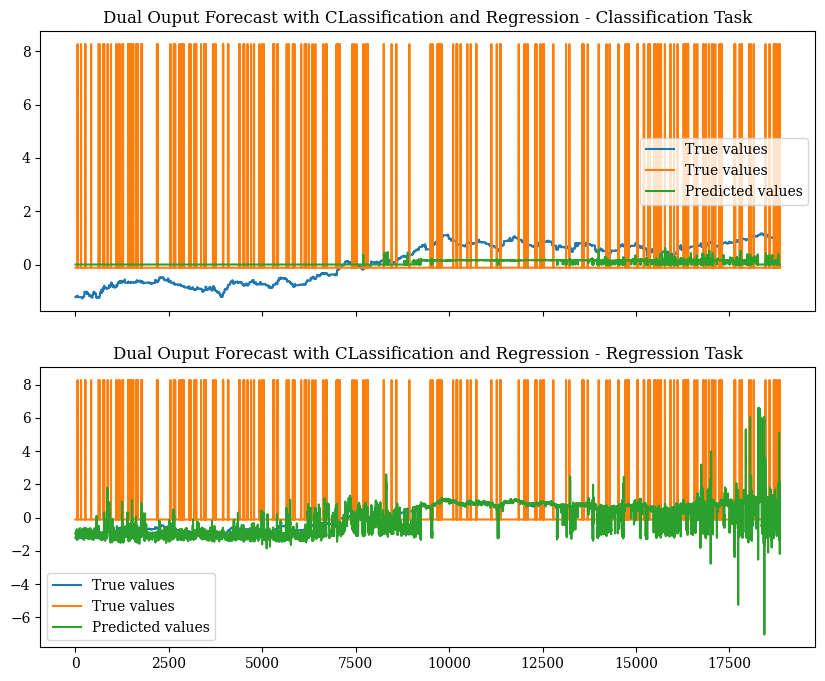

In [60]:
plot_predictions_dual(model_dual, X_test_dual, y_test_dual, "Dual Ouput Forecast with CLassification and Regression")

1. Reconstruction Metrics/Autoencoders: MSE, L1 Loss and Binary Cross Entropy https://www.v7labs.com/blog/autoencoders-guide#:~:text=Reconstruction%20Loss%3A%20The%20loss%20function,MSE%20Loss%20and%20L1%20Loss.